### Predict which Minor Leaguers will Achieve  5  WAR in MLB
This script builds and tests models for predicting which minor leagures will appear in the major leagues and obtain at least five [baseball referece WAR](https://www.baseball-reference.com/about/war_explained.shtml). It takes in minor league profiles, and season by season stats, as obtained from [baseball reference](https://www.baseball-reference.com/register/).

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import re

#Sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

#Display
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)
%matplotlib inline

In [3]:
batter_profiles = pd.read_csv('milb_batter_summaries.csv')
batter_seasons = pd.read_csv('milb_all_batter_seasons.csv')

In [4]:
len(batter_profiles.milb_id.unique())

17525

__Helper Functions__

Add Useful Data Fields

In [5]:
def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

def add_success_year(df):
    success_year = pd.DataFrame()
    success_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df


Add Stat Calulation Functions

In [6]:
## Batting Average
# Number of Hits (divided by) Number of At Bats

# Calculate the number of single from other hit data
def calc_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

def calc_BA(df):
    ba_series = df['H']/df['AB']
    return ba_series
    
## Slugging Percentage
# Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats  
def calc_SLG(df):
    slg_series = (df['1B'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']
    return slg_series

## On Base Percentage
# (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
def calc_OBP(df):
    obp_series = (df['H'] + df['BB'] + df['HBP']) \
        / (df['AB'] + df['BB'] + df['HBP']+df['SF']) 
    return obp_series

## On Base Plus Slugging 
def calc_OPS(df):
     # On Base Plus Slugging 
    ops_series = calc_OBP(df) + calc_SLG(df)
    return ops_series

Add Aggregation Function

In [7]:
# Aggregate year by year stats into full career data.
# Requires the recalculation of rate based stats from their definitions.
def make_season_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB']
    
    
    if 'LevNum' in df.columns:
        df['LevWeight'] = df['LevNum']*df['PA']
    
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby(['milb_id','Year'])
    
    df_grouped = grouped_obj.sum()
    
    df_grouped['1B'] = calc_singles(df_grouped)
    
    # Batting Average 
    df_grouped['BA'] = calc_BA(df_grouped)
    
    # On Base Percentage
    df_grouped['OBP'] = calc_OBP(df_grouped)
    
    # Slugging Percentage
    df_grouped['SLG'] = calc_SLG(df_grouped)
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = calc_OPS(df_grouped)
    
    # Other BIO 
    # Fields where max is most important 
    test_fields = ['Age','FirstYear',
                   'SeasonNumber','SuccessYear']
    for tf in test_fields:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].max()
            
    # fields where min is most importand
    test_fields2 = ['AgeDif']
    for tf in test_fields2:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].min()
                  
    # Minor League Level Attributs
    if 'LevNum' in df.columns:
        df_grouped['LevWeighted'] = df_grouped['LevWeight']/df_grouped['PA']
        
        df_grouped['LevCount'] = grouped_obj.count()['Lev']
        df_grouped.drop('LevWeight', axis=1, inplace=True)
    
    df_grouped.reset_index(inplace=True)
    
    return df_grouped


Function for creating rate stats

In [8]:
def make_rate_stats(df):
    
    df['HR_rate'] = df['HR']/df['PA']
    df['BB_rate'] = df['BB']/df['PA']
    df['SO_rate'] = df['SO']/df['PA']
    df['IBB_rate'] = df['IBB']/df['PA']
    df['SB_rate'] = df['SB']/df['PA'] #None standard definition
    df['SB_percentage'] = df['SB']/(df['SB']+df['CS'])
    df.loc[np.isnan(df['SB_percentage']),['SB_percentage']] = 0
    
    df['GDP_rate'] = df['GDP']/df['PA']
    df['SH_rate'] = df['SH']/df['PA']
    df['SF_rate'] = df['SF']/df['PA']
    df['HBP_rate'] = df['HBP']/df['PA']
    
    
    df['SB_percentage']
    
    return df

Function to Convert Player Profile into Useful Features

In [9]:
def make_batter_profile_features(df):
    df_cleaned  = deepcopy(df)

    # --- Bats --- 
    # Try to add natural order to batting to see 
    # if it can help logistic regression too
    df_cleaned.loc[
        df_cleaned['bats'] == 'right','bats'] = 0
    df_cleaned.loc[
        df_cleaned['bats'] == 'left','bats'] = 1
    df_cleaned.loc[
        df_cleaned['bats'] == 'both','bats'] = 2

    # --- Throws --- 
    df_cleaned.loc[
        df_cleaned['throws'] == 'right','throws'] = 0
    df_cleaned.loc[
        df_cleaned['throws'] == 'left','throws'] = 1

    # --- Draft ---
    df_cleaned['draft'].fillna(value = -1, inplace=True)

    # --- Positions ---
    df_cleaned['positions'] = df['positions'].str.split(',|and')
    df_cleaned['positions'] = df_cleaned['positions'].str.get(0)
    df_cleaned['positions'] = df_cleaned['positions'].str.lower()
    df_cleaned['position_difficulty'] = df_cleaned['positions'].str.lower()

    # Crudly bin positions by value. Not specifying fielders, because older records 
    # do not designate between left, right, and center.
    pos_list = ['designated','first','fielder','third','second','catcher','shortstop']

    for p in pos_list:
        if p == 'designated':
            p_num = '0'
        elif p == 'first':
            p_num = '1'
        elif p in ['fielder','third','second']:
            p_num = '2'
        elif p in ['catcher','shortstop']:
            p_num = '3'

        df_cleaned.loc[
            df_cleaned['position_difficulty'].str.contains(p),'position_difficulty'] = p_num
        
    keep_cols = ['milb_id','draft','bats',
                     'throws','height','weight','position_difficulty']
        
    return df_cleaned[keep_cols]

Helper Function For Assessing Model Fit

In [10]:
def make_summary(pred_dict,y_test):
    summary_list = []
    for k in pred_dict.keys():
        temp_dict = {}
        temp_dict['model'] = k
        temp_dict['logloss'] = metrics.log_loss(y_test,pred_dict[k])
        temp_dict['accuracy'] = metrics.accuracy_score(
            y1_test,
            np.round(pred_dict[k][:,1]))

        # Precision Recall Metrics
        p, r, f, s = metrics.precision_recall_fscore_support(
            y_test,
            np.round(pred_dict[k][:,1]),
            labels = [0,1])
        temp_dict['precision'] = p[1]
        temp_dict['recall'] = r[1]
        temp_dict['f1'] = f[1]
        temp_dict['support'] = s[1]

        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_dict[k][:,1])
        temp_dict['auc'] = metrics.auc(fpr, tpr)   

        # Append Results to List
        summary_list.append(temp_dict)

    # Put Results in DataFrame
    results1_df = pd.DataFrame(summary_list)
    results1_df.set_index(results1_df.model,inplace = True)
    return results1_df

def make_precision_recall_curves(pred_dict,y_test):
    leg = []
    plt.figure(figsize=(8, 6))
    for k in pred_dict.keys():
        prec, recall, thresholds = metrics.precision_recall_curve(
            y_test,pred_dict[k][:,1])

        plt.plot(prec[0:-1], recall[0:-1])
        leg.append(k)

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(leg)
    plt.title('Multiple Models: Attempt 1')

def make_roc_curves(pred_dict,y_test):
    leg = []
    plt.figure(figsize=(8, 6))
    for k in pred_dict.keys():
        fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_dict[k][:,1])
        plt.plot(fpr, tpr)
        leg.append(k)
        
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))    
    plt.legend(leg)
    plt.title('Multiple Models: ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')

def make_feature_importance_charts(pred_dict,model_dict,X):
    num_subplots = len(pred_dict.keys())
    f, axs = plt.subplots(num_subplots,1,figsize=(20,6*num_subplots))
    f.subplots_adjust(hspace=.5)

    count = 1

    for k in pred_dict.keys():
        if 'lm' in k:
            f_Series = pd.Series(
                model_dict[k].coef_[0],index = X.columns[1:]).sort_values()
        elif 'gs' in k:
            f_Series = pd.Series(model_dict[k].best_estimator_.feature_importances_,
                                 index = X.columns[1:]).sort_values()
        else:
            f_Series = pd.Series(model_dict[k].feature_importances_,index = X.columns[1:]).sort_values()

        plt.subplot(num_subplots,1,count)
        g = sns.barplot(x = f_Series.index,y = f_Series)
        g.set_xticklabels(f_Series.index, rotation=-30,size=12)
        plt.title(k, size = 16)
        plt.ylabel('Feature Importance',size=14);
        plt.xlabel('Feature',size=14);
        count += 1
        

__Filtering and Aggregation__

In [11]:
batter_seasons_filt = deepcopy(batter_seasons)

# Drop Aggregated Seasons. Will Recompute
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt.Tm.str.contains('Teams') == False]

In [12]:
# Map Each League to a level
lev_dict = {'FRk':0,'Rk':1,'A-':2,'A':3,'A+':4,'AA':5,'AAA':6}
level_map = pd.Series(batter_seasons_filt.loc[:,('Lev')].map(lev_dict))
batter_seasons_filt['LevNum'] = level_map

# Drop Leagues that are "Atypical"
weird_leagues = ['Ind','Rk','FRk','WRk','FgW','Fal','Fgn','Wtr']
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lev'].isin(weird_leagues) == False]
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lg'] != 'MEX']

In [13]:
# Remove Seasons that occured after player made the majors
majors_df = batter_seasons_filt[
    batter_seasons_filt.Lev == 'MLB'][['milb_id','Year']]

mlb_debuts = majors_df.groupby('milb_id').min().reset_index()
mlb_debuts.rename(columns={'Year':'SuccessYear'},inplace=True)

batter_seasons_filt = batter_seasons_filt.merge(
    mlb_debuts, how = 'left',on= 'milb_id')

batter_seasons_filt = batter_seasons_filt[
    (batter_seasons_filt['SuccessYear'] > batter_seasons_filt['Year']) | 
    pd.isnull(batter_seasons_filt['SuccessYear'])] 


In [14]:
# Remove Players Who had their first season before 1990.
batter_seasons_filt = add_season_number(batter_seasons_filt)
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] > 1990]

batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] < 2012]

In [15]:
batter_seasons_total = make_season_stats(batter_seasons_filt)
batter_seasons_total = make_rate_stats(batter_seasons_total)

In [16]:
## Add dependent variable
batter_seasons_total = batter_seasons_total.merge(
    batter_profiles.loc[:,['milb_id','mlb','war']],
    how = 'left',
    on = 'milb_id')

In [17]:

# Set a threshold of 5 WAR, indicating the player provided some value
# his career
batter_seasons_total['Big_war']=0
batter_seasons_total.loc[batter_seasons_total['war']>=5,['Big_war']] = 1 

In [18]:
bst_test = deepcopy(batter_seasons_total)

In [19]:
bst_test = bst_test.loc[bst_test['SeasonNumber'] == 2,:]

#bst_test = bst_test.loc[(bst_test['LevWeighted'] >= 3)&(bst_test['LevWeighted'] >= 3),:]
bst_test = bst_test.loc[bst_test['PA'] > 150,:]

In [20]:
np.shape(bst_test)

(7123, 47)

### Model Stuff

Start by using Features from Season Data

In [21]:
test_cols = ['milb_id','LevWeighted','AgeDif','PA',
             'BA','OBP','SLG','HR_rate',
             'BB_rate','SO_rate','IBB_rate',
             'SB_rate','SB_percentage','GDP_rate',
             'SH_rate','HBP_rate']


# test_cols = ['milb_id','LevWeighted',
#              'BA','OBP','SLG','HR_rate',
#              'BB_rate','SO_rate','IBB_rate',
#              'SB_rate','SB_percentage','GDP_rate',
#              'SH_rate','HBP_rate']


X1 = bst_test.loc[:,test_cols]
y1 = bst_test.loc[:,['Big_war']]

X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    X1, y1, test_size=0.3)

y1_train = np.ravel(y1_train)
y1_test = np.ravel(y1_test)

In [22]:
# Baseline Prediction
#sum(y1)/len(y1)
baseline1 = sum(y1_train)/len(y1_train)
baseline1

0.059767348576012833

Try a few algorithms "out of the box," to see how they do.

In [23]:
pred_dict = {}
model_dict = {}

lm1 = linear_model.LogisticRegression()
lm1.fit(X1_train.iloc[:,1:],y1_train)
pred_dict['lm1'] = lm1.predict_proba(X1_test.iloc[:,1:])
model_dict['lm1'] = lm1

rf1 = ensemble.RandomForestClassifier(
    n_estimators=1000,
    min_samples_leaf = 5)
rf1.fit(X1_train.iloc[:,1:],y1_train)
pred_proba_rf1 = rf1.predict_proba(X1_test.iloc[:,1:])
pred_dict['rf1'] = rf1.predict_proba(X1_test.iloc[:,1:])
model_dict['rf1'] = rf1

gb1 = ensemble.GradientBoostingClassifier(
    learning_rate=.01,
    subsample=0.3,
    max_depth=4,
    n_estimators = 1000)
gb1.fit(X1_train.iloc[:,1:],y1_train)
pred_dict['gb1'] = gb1.predict_proba(X1_test.iloc[:,1:])
model_dict['gb1'] = gb1

In [24]:
make_summary(pred_dict,y1_test)

,accuracy,auc,f1,logloss,model,precision,recall,support
model,,,,,,,,
lm1,0.940103,0.854003,0.098592,0.173714,lm1,0.538462,0.054264,129
rf1,0.941039,0.841066,0.059701,0.176911,rf1,0.800000,0.031008,129
gb1,0.936359,0.839410,0.235955,0.182404,gb1,0.428571,0.162791,129


__Look at Results of Models at Various Threasholds__

Precision and recall at 50% cutoff

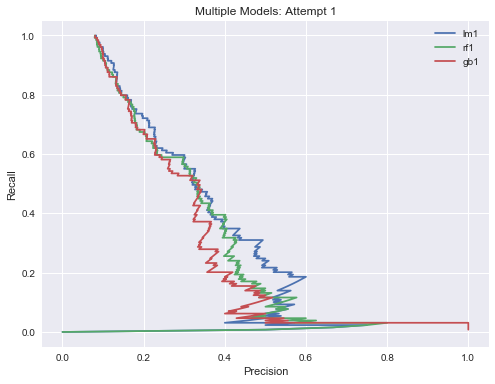

In [25]:
make_precision_recall_curves(pred_dict,y1_test)

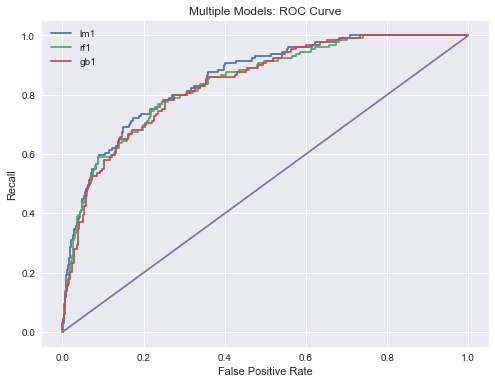

In [26]:
 make_roc_curves(pred_dict,y1_test)

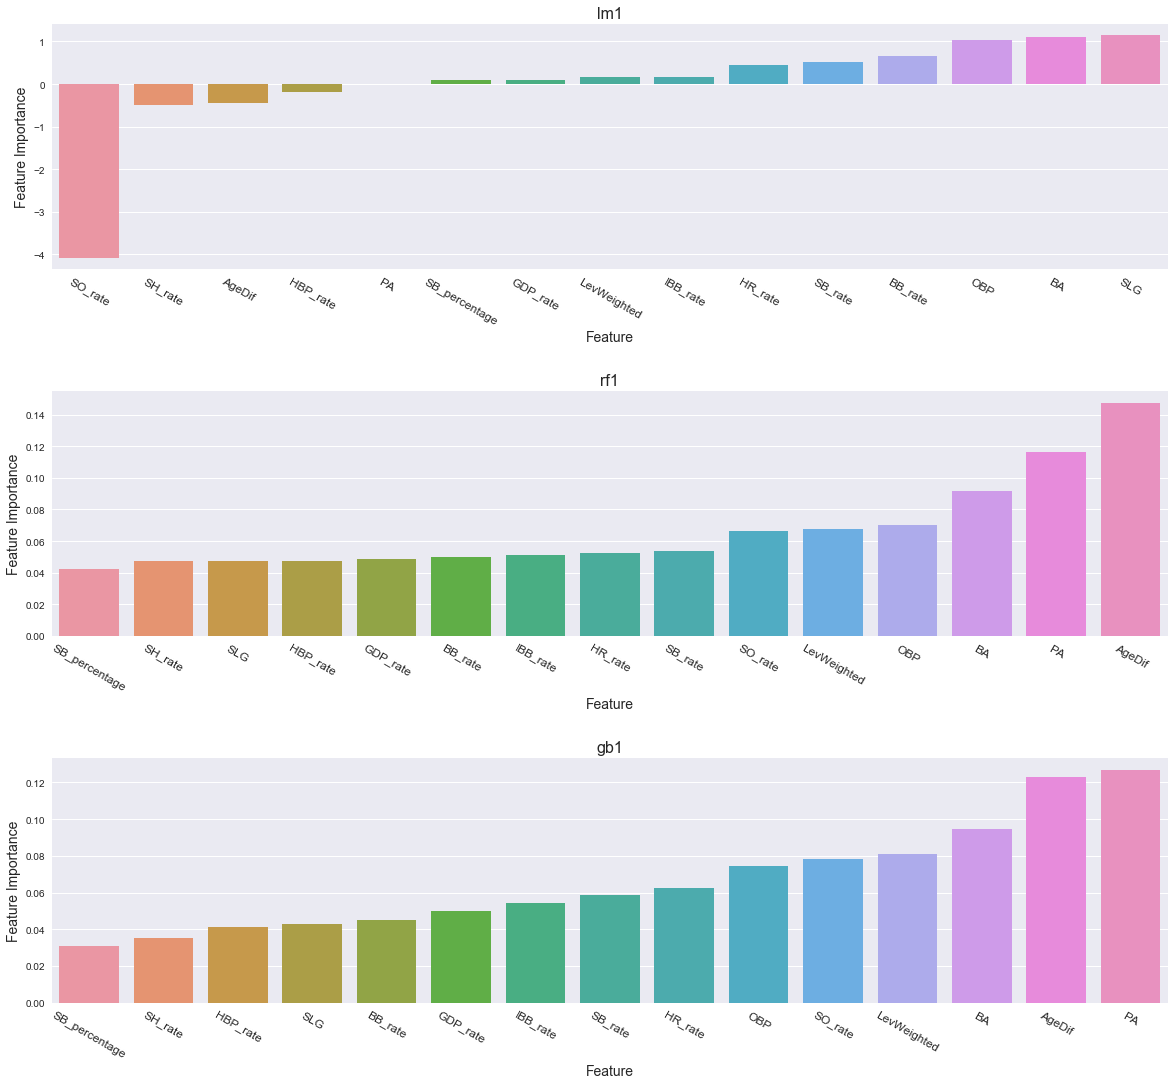

In [27]:
make_feature_importance_charts(pred_dict,model_dict,X1_test)

All models are performing about the same. However, more RF and GB trees can have additional categorical variables added to them. Moreover, Gradient descent can be used to tune these models further. 

__Add additional features from Player Profile DF__

In [28]:
batter_profile_features = make_batter_profile_features(batter_profiles)

Merge on old X1 train and test so I can have the same players in each group as before, for comparison.

In [29]:
X2_train = X1_train.merge(batter_profile_features,how='left',on='milb_id')
X2_test = X1_test.merge(batter_profile_features,how='left',on='milb_id')

# Remove Useless Features
X2_train = X2_train.drop(axis=1,labels=['bats','throws','weight'])
X2_test = X2_test.drop(axis=1,labels=['bats','throws','weight'])

In [30]:
y2_train = y1_train
y2_test = y1_test

In [31]:
lm2 = linear_model.LogisticRegression()
lm2.fit(X2_train.iloc[:,1:],y2_train)
pred_dict['lm2'] = lm2.predict_proba(X2_test.iloc[:,1:])
model_dict['lm2'] = lm2

rf2 = ensemble.RandomForestClassifier(
    n_estimators=1000,
    min_samples_leaf = 5)
rf2.fit(X2_train.iloc[:,1:],y1_train)
pred_proba_rf2 = rf2.predict_proba(X2_test.iloc[:,1:])
pred_dict['rf2'] = rf2.predict_proba(X2_test.iloc[:,1:])
model_dict['rf2'] = rf2

gb2 = ensemble.GradientBoostingClassifier(
    learning_rate=.01,
    subsample=0.3,
    max_depth=4,
    n_estimators = 1000)
gb2.fit(X2_train.iloc[:,1:],y2_train)
pred_dict['gb2'] = gb2.predict_proba(X2_test.iloc[:,1:])
model_dict['gb2'] = gb2

In [32]:
summary_df = make_summary(pred_dict,y1_test)
summary_df.sort_values('logloss',ascending=True)

,accuracy,auc,f1,logloss,model,precision,recall,support
model,,,,,,,,
lm2,0.939635,0.858334,0.097902,0.171079,lm2,0.500000,0.054264,129
lm1,0.940103,0.854003,0.098592,0.173714,lm1,0.538462,0.054264,129
rf2,0.939635,0.848617,0.044444,0.173964,rf2,0.500000,0.023256,129
gb2,0.942911,0.849146,0.298851,0.174920,gb2,0.577778,0.201550,129
rf1,0.941039,0.841066,0.059701,0.176911,rf1,0.800000,0.031008,129
gb1,0.936359,0.839410,0.235955,0.182404,gb1,0.428571,0.162791,129


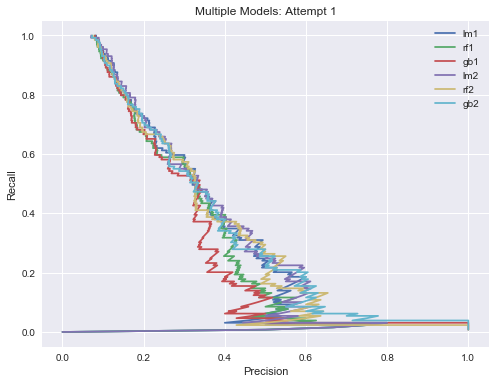

In [33]:
make_precision_recall_curves(pred_dict,y1_test)

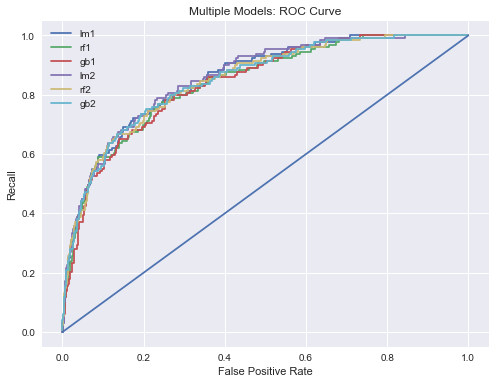

In [34]:
make_roc_curves(pred_dict,y1_test)

In [35]:
new_keys = ['lm2','rf2','gb2']
pred_dict_new =  dict([(k, pred_dict[k]) for k in new_keys ])
model_dict_new =  dict([(k, model_dict[k]) for k in new_keys])

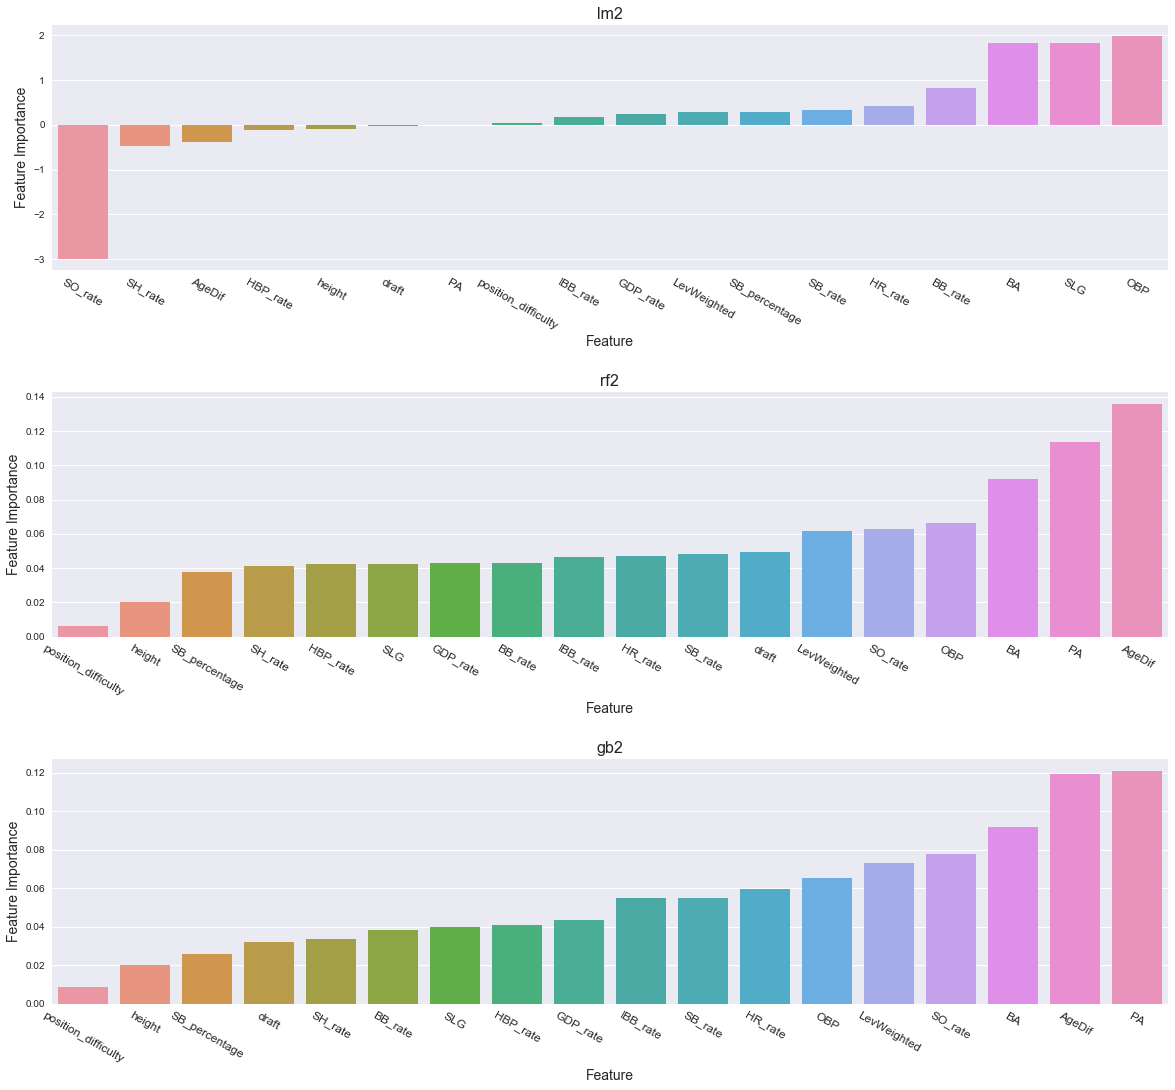

In [36]:
make_feature_importance_charts(pred_dict_new,model_dict_new,X2_test)

In [37]:
np.shape(pred_dict['lm2'])

(2137, 2)

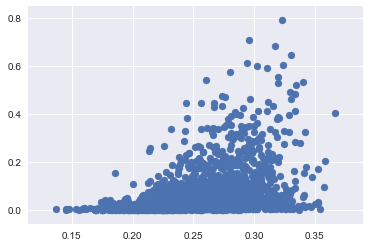

In [38]:
plt.scatter(X2_test['BA'],pred_dict['lm2'][:,1])

__ Optimize Random Forest and Gradient Boosted Trees__

It appears that gradiant boosted trees and random forest with player profile info are performing the best. Let's see if they can be further improved through grid search cross validation.

In [39]:
rf_param_grid = {'min_samples_leaf': [2, 5, 10, 15],
                 'n_estimators':[500,1000]}


rf3 = ensemble.RandomForestClassifier()
rfgs = model_selection.GridSearchCV(rf3,rf_param_grid)
rfgs.fit(X2_train.iloc[:,1:],y1_train)


rf3 = ensemble.RandomForestClassifier()
for k,v in rfgs.best_params_.items():
    setattr(rf3,k,v)

rf3.fit(X2_train.iloc[:,1:],y1_train)
pred_dict['rf3'] = rf3.predict_proba(X2_test.iloc[:,1:])
model_dict['rf3'] = rf3

In [40]:
gb_parameter_grid = {'subsample':[0.5,0.7,0.8],
    'max_depth':[2,3,4,5],
    'n_estimators':[500,1000,1500,2000],
    'learning_rate':[0.005,0.01]}


gb3 = ensemble.GradientBoostingClassifier()
gbgs = model_selection.GridSearchCV(gb3,gb_parameter_grid,cv=5)
gbgs.fit(X2_train.iloc[:,1:],y1_train)
pred_proba_gbgs = gbgs.predict_proba(X2_test.iloc[:,1:])
                  
gbgs.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=0.7, verbose=0, warm_start=False)

In [41]:
gb3 = ensemble.GradientBoostingClassifier()
for k,v in gbgs.best_params_.items():
    setattr(gb3,k,v)

In [42]:
gb3.fit(X2_train.iloc[:,1:],y1_train)
pred_dict['gb3'] = gb3.predict_proba(X2_test.iloc[:,1:])
model_dict['gb3'] = gb3

In [43]:
summary_df = make_summary(pred_dict,y1_test)
summary_df.sort_values('logloss',ascending=True)

,accuracy,auc,f1,logloss,model,precision,recall,support
model,,,,,,,,
lm2,0.939635,0.858334,0.097902,0.171079,lm2,0.500000,0.054264,129
gb3,0.943379,0.856346,0.248447,0.172245,gb3,0.625000,0.155039,129
lm1,0.940103,0.854003,0.098592,0.173714,lm1,0.538462,0.054264,129
rf2,0.939635,0.848617,0.044444,0.173964,rf2,0.500000,0.023256,129
gb2,0.942911,0.849146,0.298851,0.174920,gb2,0.577778,0.201550,129
rf3,0.940103,0.842622,0.072464,0.175913,rf3,0.555556,0.038760,129
rf1,0.941039,0.841066,0.059701,0.176911,rf1,0.800000,0.031008,129
gb1,0.936359,0.839410,0.235955,0.182404,gb1,0.428571,0.162791,129


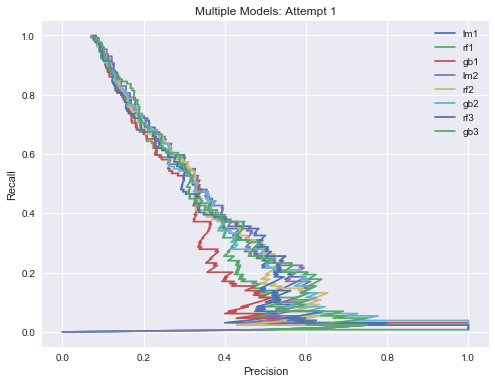

In [44]:
make_precision_recall_curves(pred_dict,y1_test)

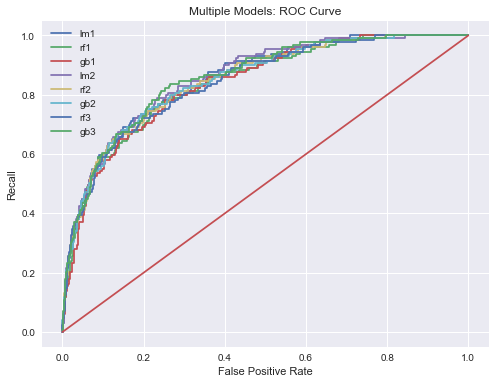

In [45]:
make_roc_curves(pred_dict,y1_test)

In [46]:
new_keys = ['rf2','gb2','rf3','gb3']
pred_dict_new =  dict([(k, pred_dict[k]) for k in new_keys ])
model_dict_new =  dict([(k, model_dict[k]) for k in new_keys])

In [47]:
gb3.feature_importances_

array([ 0.08768062,  0.15814524,  0.14572996,  0.10430334,  0.05327035,
        0.01553141,  0.05911112,  0.0223178 ,  0.09814356,  0.04345127,
        0.04358955,  0.01743151,  0.0274897 ,  0.02970578,  0.02856187,
        0.04485222,  0.01321399,  0.00747073])

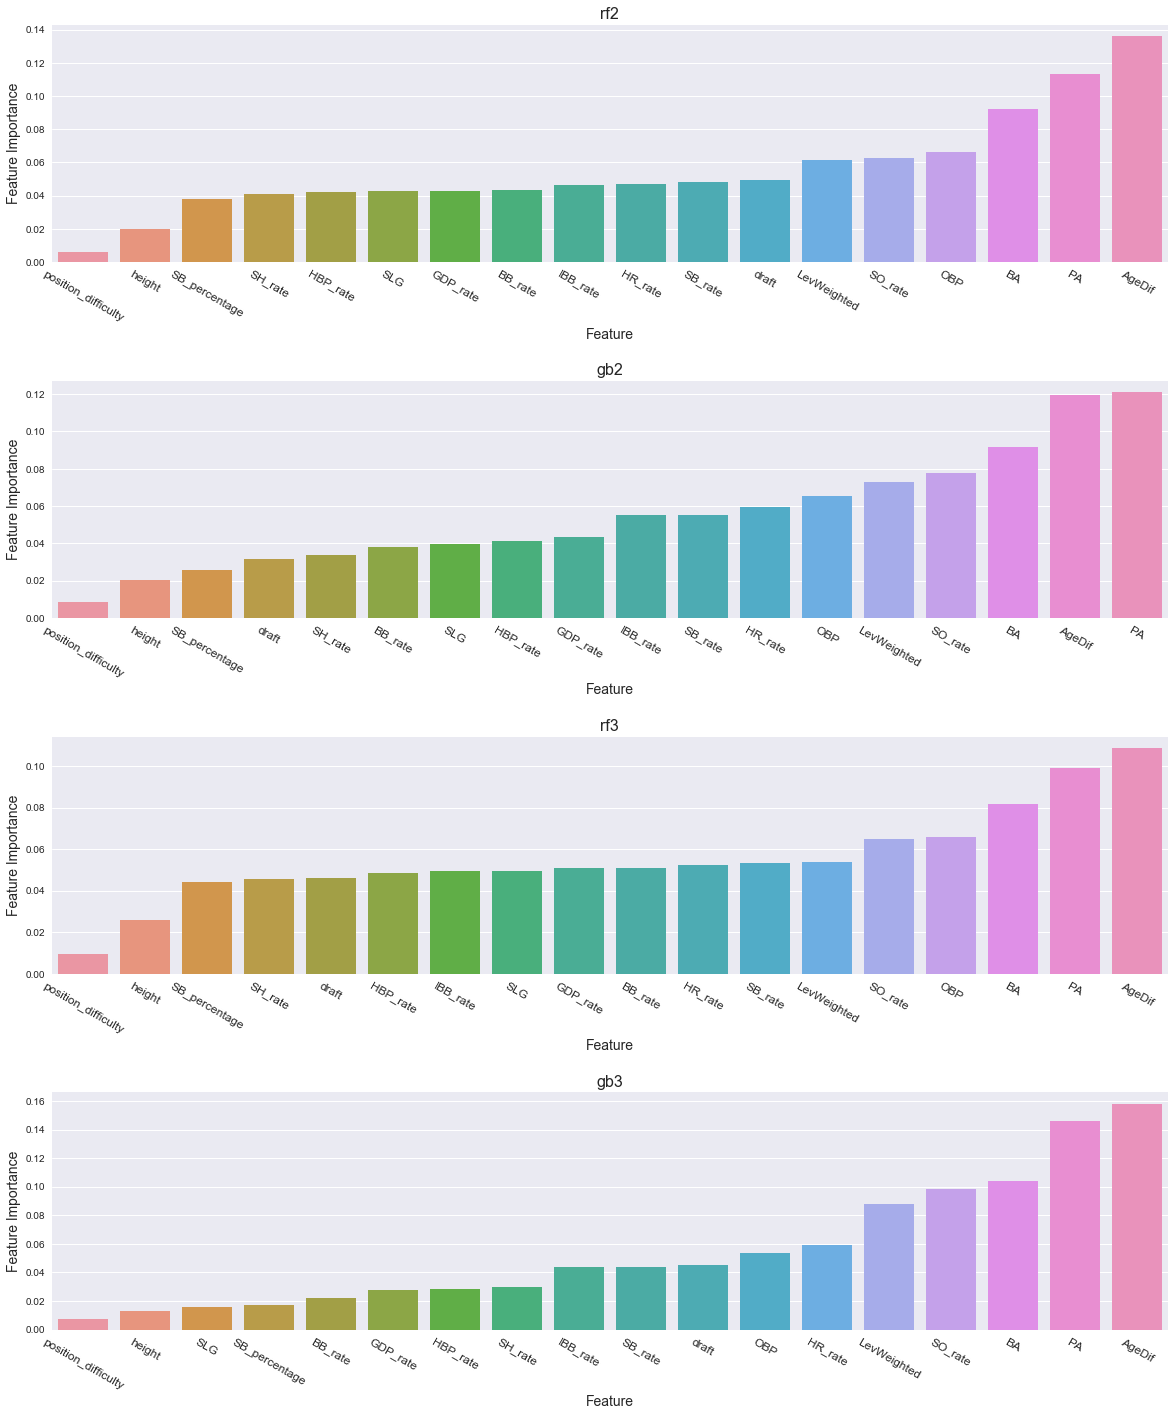

In [48]:
make_feature_importance_charts(pred_dict_new,model_dict_new,X2_test)

Make gradient boosted grid search that is tuned to the strongest
predictors

In [49]:
# Test precision of model, but only at the top k percentile strongest
def precision_at_k(y_true, y_score, k):
    #df = pd.DataFrame({'true': y_true, 'score': y_score}).sort('score')
    y_score = y_score[:,1]
    df = pd.DataFrame({'true': y_true.tolist(),
                       'score': y_score.tolist()}).sort_values('score',ascending=False)
    threshold = df.iloc[int(k*len(df)),0]
    
    y_pred = pd.Series([1 if i >= threshold else 0 for i in df['score']])
    return metrics.precision_score(df['true'], y_pred)

custom_scorer = metrics.make_scorer(precision_at_k, needs_proba=True, k=0.3)

In [50]:
custom_scorer = metrics.make_scorer(metrics.average_precision_score)

Actually do the grid search

In [51]:
gb_parameter_grid = {'subsample':[0.5,0.8,0.9],
    'max_depth':[2,3,4,5],
    'n_estimators':[500,1000,1500,2000],
    'learning_rate':[0.005,0.01]}

gb4 = ensemble.GradientBoostingClassifier()
gbgs2 = model_selection.GridSearchCV(gb4,
                                    gb_parameter_grid,
                                    cv=5,
                                    scoring=custom_scorer)
gbgs2.fit(X2_train.iloc[:,1:],y1_train)
gbgs2.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.9}

In [52]:
gbgs2.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.9}

In [53]:
gb4 = ensemble.GradientBoostingClassifier()
for k,v in gbgs2.best_params_.items():
    setattr(gb4,k,v)

gb4.fit(X2_train.iloc[:,1:],y1_train)

pred_proba_gbgs = gb4.predict_proba(X2_test.iloc[:,1:])
pred_dict['gb4'] = gb4.predict_proba(X2_test.iloc[:,1:])
model_dict['gb4'] = gb4

In [54]:
summary_df = make_summary(pred_dict,y1_test)
summary_df.sort_values('precision',ascending=False)

,accuracy,auc,f1,logloss,model,precision,recall,support
model,,,,,,,,
rf1,0.941039,0.841066,0.059701,0.176911,rf1,0.800000,0.031008,129
gb4,0.943379,0.856188,0.238994,0.171899,gb4,0.633333,0.147287,129
gb3,0.943379,0.856346,0.248447,0.172245,gb3,0.625000,0.155039,129
gb2,0.942911,0.849146,0.298851,0.174920,gb2,0.577778,0.201550,129
rf3,0.940103,0.842622,0.072464,0.175913,rf3,0.555556,0.038760,129
lm1,0.940103,0.854003,0.098592,0.173714,lm1,0.538462,0.054264,129
lm2,0.939635,0.858334,0.097902,0.171079,lm2,0.500000,0.054264,129
rf2,0.939635,0.848617,0.044444,0.173964,rf2,0.500000,0.023256,129
gb1,0.936359,0.839410,0.235955,0.182404,gb1,0.428571,0.162791,129


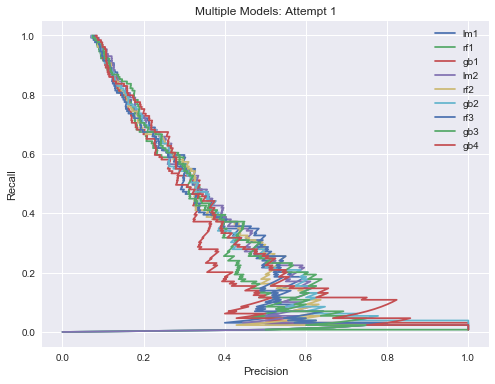

In [55]:
make_precision_recall_curves(pred_dict,y1_test)

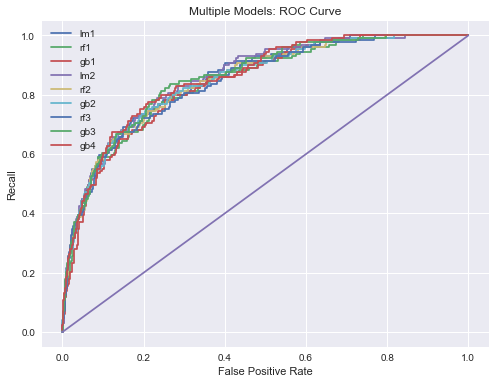

In [56]:
make_roc_curves(pred_dict,y1_test)

In [57]:
new_keys = ['rf2','gb2','gb4']
pred_dict_new =  dict([(k, pred_dict[k]) for k in new_keys ])
model_dict_new =  dict([(k, model_dict[k]) for k in new_keys])

In [58]:
gb4.feature_importances_

array([ 0.06489209,  0.10234433,  0.11388236,  0.10921912,  0.04649067,
        0.03301231,  0.05791144,  0.04077529,  0.08964269,  0.04469263,
        0.06782978,  0.02623431,  0.04565149,  0.04238471,  0.05112111,
        0.03532238,  0.01839469,  0.0101986 ])

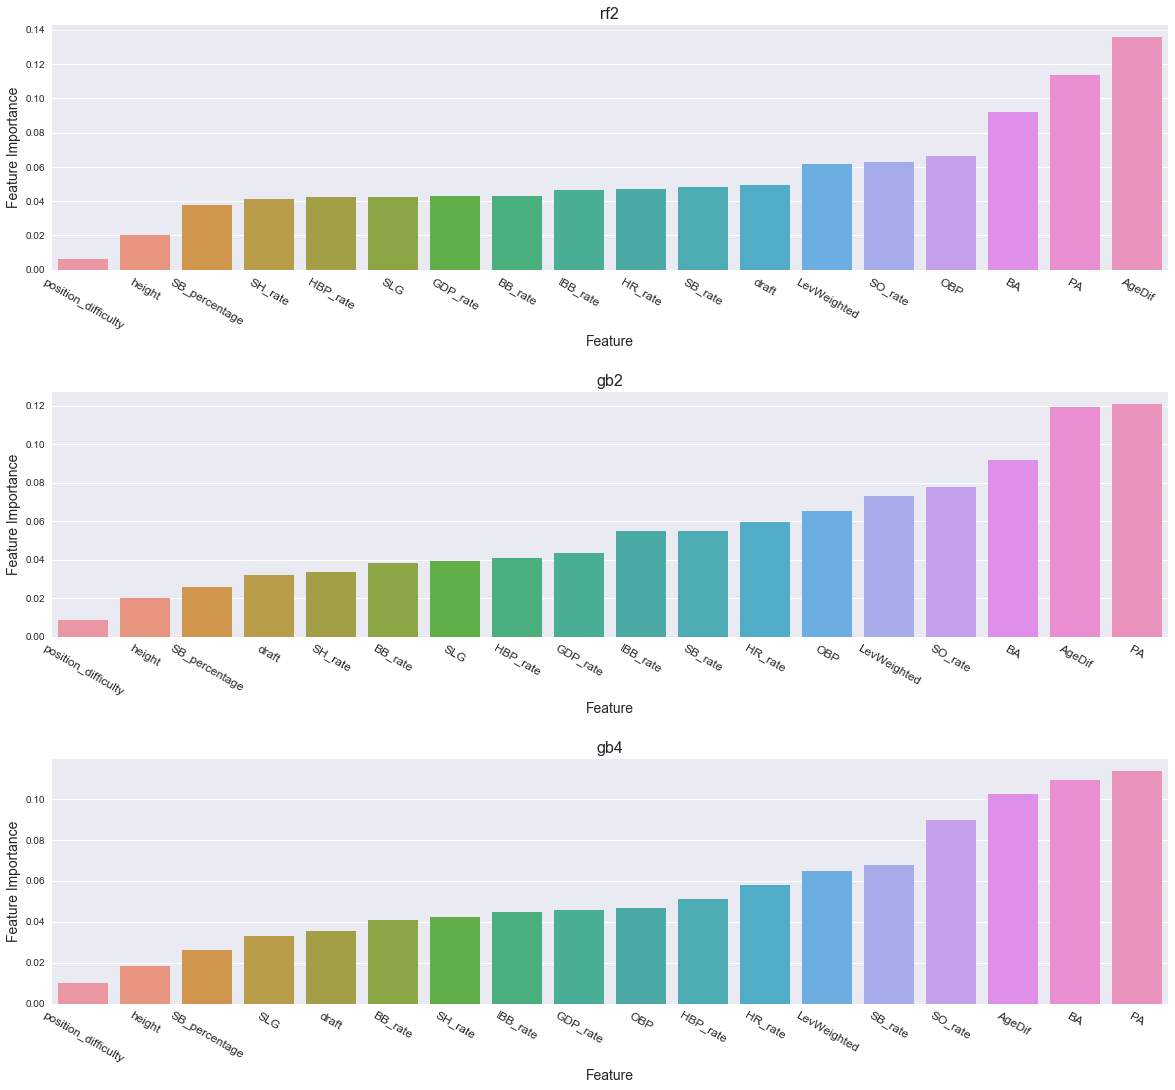

In [59]:
make_feature_importance_charts(pred_dict_new,model_dict_new,X2_test)

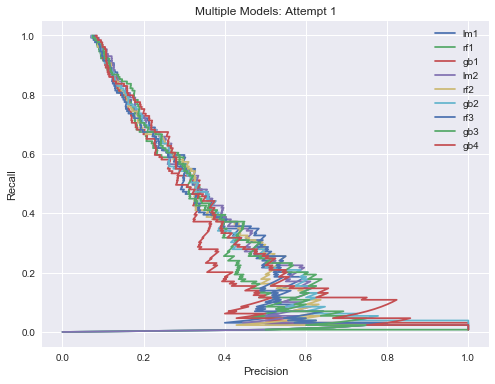

In [60]:
make_precision_recall_curves(pred_dict,y1_test)

__Having seen all of the models, pick the ones to present__

In [61]:
new_keys = ['lm1','rf2']
pred_dict_new =  dict([(k, pred_dict[k]) for k in new_keys ])
model_dict_new =  dict([(k, model_dict[k]) for k in new_keys])

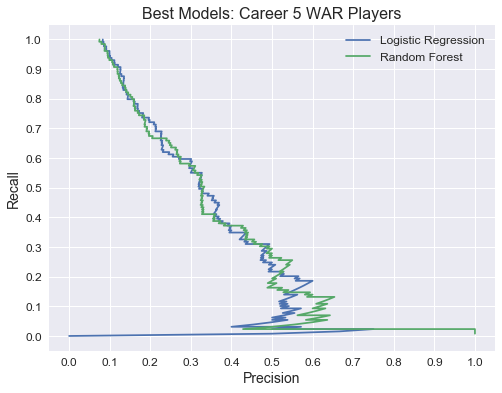

In [62]:
make_precision_recall_curves(pred_dict_new,y1_test)
plt.legend(['Logistic Regression','Random Forest'], prop={'size':12 })

plt.title('Best Models: Career 5 WAR Players',size = 16);
plt.xlabel('Precision',size = 14);
plt.ylabel('Recall', size = 14);
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize = 12);
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], fontsize = 12);

Estimate How Many Players I would find with a Recall of .20 each year

In [ ]:
good_players = batter_seasons_total.loc[
    (batter_seasons_total['Year'] < 2005) & 
    (batter_seasons_total['mlb'] == 1) &
    (batter_seasons_total['war'] >=5) &
    (batter_seasons_total['SeasonNumber'] == 2)]

In [ ]:
good_per_year = np.shape(good_players.groupby(['milb_id','Year']))[0]/float(len(good_players.Year.unique()))

In [ ]:
good_per_year*.20

Not that many players.